In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import csv
from datetime import datetime, timedelta
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.keras.backend.set_floatx('float64')
from tensorflow.keras import regularizers
from tensorflow import keras

2022-11-28 20:41:24.793734: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-28 20:41:24.793774: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:

def acc_prec_rec(TP, FN, TN, FP):
    # accuracy = proportion of true results among the total number of cases examined
    accuracy = (TP+TN)/(TP+FP+FN+TN)
    
    # precision = what proportion of predicted Positives is truly positive
    print('TP',TP)
    print('FP',FP)
    if TP ==0:
        if FP ==0:
            precision = 0
    else:
        precision = (TP)/(TP+FP)
    
    #recall = what proportion of actual Positives is correctly classified (= True positive rate)
    # = sensitivity
    if TP ==0:
        if FN ==0:
            recall = 0
        else:
            recall = (TP)/(TP+FN)
    else: 
        recall = (TP)/(TP+FN)
    #specificity (=False positive rate)
    if TN ==0:
        if FP ==0:
            specificity =0
        else:
            specificity = (TN)/(TN + FP)
    else:
        specificity = (TN)/(TN + FP)
    
    # F1 score: number between 0 and 1, harmonic mean of precision and recall
    if precision + recall == 0:
        F1 = 0
    else:
        F1 = 2*(precision*recall)/(precision + recall)
    
    confusion_matrix = [[TP, FP],[FN,TN]]
    confusion_matrix = np.array(confusion_matrix)/np.array(confusion_matrix).sum(axis = 1)
    
    print('accuracy: ', accuracy)
    print('precision: ', precision)
    print('sensitivity (recall): ', recall)
    print('specificity: ', specificity)
    print('F1: ',F1)
    return accuracy, precision, recall, specificity, F1, confusion_matrix    
    
scale_min = 0
scale_max = 1
def scaling(df,df_min,df_max,scale_min,scale_max):
    df_std = (df-df_min) / (df_max-df_min)
    df_scaled = df_std* (scale_max - scale_min)+scale_min
    return df_scaled

def scaling_reverse(df,df_min,df_max,scale_min,scale_max):
    df_scaled_reverse = (df-scale_min)/(scale_max-scale_min)*(df_max-df_min)+df_min
    return df_scaled_reverse    

In [3]:
def compute_dust_events(dataframe):
    dataframe1 = list()
    k2 = list()
    for i in range(len(dataframe['sde_event'])):
        if dataframe['sde_event'].loc[i]>=0.5:
            k2.append(i)
    
    k1 = list()
    for el in k2:
        if el+3 in k2:
            if el+2 in k2:
                if el+1 in k2:
                    k1.append(el)        
    sde_event_1s = np.zeros_like(dataframe['sde_event'].values)
    
    for j in k1:
        sde_event_1s[j:j+4]=np.array([1,1,1,1])
    
    dataframe['sde_event_predicted']=sde_event_1s
    return dataframe

In [4]:
def number_noevents_dates(dataframe, event_name, event_col):
    dataframe[event_col]=0
    num = 1
    for k,v in dataframe.groupby((dataframe[event_name].shift() !=dataframe[event_name]).cumsum()):
   #     print(f'[group{k}]')
   #     print(v[event_name])
   #     print('\n')
    
        if v[event_name].all() ==0:
            dataframe[event_col].loc[v.index]=num
           # print(v.index)
            num = num+1
            
    return dataframe

In [5]:
def number_noevents_data(dataframe, noevent_col, event_name, event_col):
    num_nosde = 1
    num_sde = 1
    dataframe[noevent_col]=0
    dataframe[event_col]=0
    for k,v in dataframe.groupby((dataframe[event_name].shift() !=dataframe[event_name]).cumsum()):
        if v[event_name].all() ==0:
            dataframe[noevent_col].loc[v.index]=num_nosde
            num_nosde = num_nosde+1
        if v[event_name].all() ==1:
            dataframe[event_col].loc[v.index]=num_sde
            num_sde = num_sde+1
    return dataframe
    

In [24]:
def metric_sde(dates, qoi_val_pred):
    count_sde = 0
    count_nosde = 0
    dust_event_nrs = dates['sde_event_nr'].unique()[1:]
    nodust_event_nrs = dates['nosde_event_nr'].unique()[1:]

    for ev in (dust_event_nrs):
        #print('dust_event_number: ',ev)
        ev_index = dates[dates['sde_event_nr']==ev].index
        #print(qoi_val_pred['sde_event_predicted'].loc[ev_index].sum())
        if qoi_val_pred['sde_event_predicted'].loc[ev_index].sum() >0:
            count_sde = count_sde+1

    for noev in (nodust_event_nrs):
        #print('nodust_event_number: ',noev)
        noev_index = dates[dates['nosde_event_nr']==noev].index
        #print(qoi_val_pred['sde_event_predicted'].loc[noev_index].sum())
        if qoi_val_pred['sde_event_predicted'].loc[noev_index].sum() >0:
            count_nosde = count_nosde
        else:
            count_nosde = count_nosde +1
    N_sde_truth = len(dust_event_nrs) 
    N_nosde_truth = len(nodust_event_nrs)
    TP = count_sde
    FN = N_sde_truth - TP
    TN = count_nosde
    FP = N_nosde_truth - count_nosde
    N_sde_pred = qoi_val_pred['sde_event_predicted_nr'].max()
    N_nosde_pred = qoi_val_pred['nosde_event_predicted_nr'].max()

   # print('true number sde: ', N_sde_truth )
   # print('true number nosde: ', N_nosde_truth)
   # print('predicted number sde: ',N_sde_pred )
    
   # print('predicted number nosde: ', N_nosde_pred)
    print('True positive: ', TP)
    print('False negative: ',FN)
    print('True negative: ', TN)
    print('False positive: ',FP)

    result = [N_sde_truth, N_nosde_truth, N_sde_pred, N_nosde_pred, TP, FN, TN, FP]
    
    return result


In [25]:
df_results = pd.DataFrame()
rowdict =  {
0: '#sde_truth',
1: '#nosde_truth',
2: '#sde_pred',
3: '#nosde_pred',   
4:'TP' ,
5: "FN",
6: 'TN',
7:'FP',
8:'accuracy',
9:'precision',
10:'recall',
11: 'specificity',
12: 'F1', 

} 

Model:  0


/data/user/boiger_r/python_env/aerosol_env_mie/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/tmp/ipykernel_42703/2797755789.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[event_col]=0


Validation
True positive:  2
False negative:  0
True negative:  1
False positive:  1
[2, 2, 2, 3, 2, 0, 1, 1]
TP 2
FP 1
accuracy:  0.75
precision:  0.6666666666666666
sensitivity (recall):  1.0
specificity:  0.5
F1:  0.8
Training
True positive:  15
False negative:  9
True negative:  16
False positive:  8
TP 15
FP 8
accuracy:  0.6458333333333334
precision:  0.6521739130434783
sensitivity (recall):  0.625
specificity:  0.6666666666666666
F1:  0.6382978723404256
Whole dataframe
True positive:  17
False negative:  9
True negative:  17
False positive:  8
TP 17
FP 8
accuracy:  0.6666666666666666
precision:  0.68
sensitivity (recall):  0.6538461538461539
specificity:  0.68
F1:  0.6666666666666666
Model:  1


/data/user/boiger_r/python_env/aerosol_env_mie/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/tmp/ipykernel_42703/2797755789.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[event_col]=0


Validation
True positive:  1
False negative:  0
True negative:  1
False positive:  1
[1, 2, 6, 7, 1, 0, 1, 1]
TP 1
FP 1
accuracy:  0.6666666666666666
precision:  0.5
sensitivity (recall):  1.0
specificity:  0.5
F1:  0.6666666666666666
Training
True positive:  19
False negative:  6
True negative:  17
False positive:  7
TP 19
FP 7
accuracy:  0.7346938775510204
precision:  0.7307692307692307
sensitivity (recall):  0.76
specificity:  0.7083333333333334
F1:  0.7450980392156863
Whole dataframe
True positive:  20
False negative:  6
True negative:  17
False positive:  8
TP 20
FP 8
accuracy:  0.7254901960784313
precision:  0.7142857142857143
sensitivity (recall):  0.7692307692307693
specificity:  0.68
F1:  0.7407407407407408
Model:  2


/data/user/boiger_r/python_env/aerosol_env_mie/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/tmp/ipykernel_42703/2797755789.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[event_col]=0


Validation
True positive:  2
False negative:  0
True negative:  1
False positive:  2
[2, 3, 3, 4, 2, 0, 1, 2]
TP 2
FP 2
accuracy:  0.6
precision:  0.5
sensitivity (recall):  1.0
specificity:  0.3333333333333333
F1:  0.6666666666666666
Training
True positive:  18
False negative:  6
True negative:  16
False positive:  7
TP 18
FP 7
accuracy:  0.723404255319149
precision:  0.72
sensitivity (recall):  0.75
specificity:  0.6956521739130435
F1:  0.7346938775510204
Whole dataframe
True positive:  20
False negative:  6
True negative:  17
False positive:  8
TP 20
FP 8
accuracy:  0.7254901960784313
precision:  0.7142857142857143
sensitivity (recall):  0.7692307692307693
specificity:  0.68
F1:  0.7407407407407408
Model:  3


/data/user/boiger_r/python_env/aerosol_env_mie/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/tmp/ipykernel_42703/2797755789.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[event_col]=0
/tmp/ipykernel_42703/133789270.py:39: RuntimeWarning: divide by zero encountered in true_divide
  confusion_matrix = np.array(confusion_matrix)/np.array(confusion_matrix).sum(axis = 1)
/tmp/ipykernel_42703/133789270.py:39: RuntimeWarning: invalid value encounter

Validation
True positive:  0
False negative:  3
True negative:  4
False positive:  0
[3, 4, 0, 1, 0, 3, 4, 0]
TP 0
FP 0
accuracy:  0.5714285714285714
precision:  0
sensitivity (recall):  0.0
specificity:  1.0
F1:  0
Training
True positive:  0
False negative:  23
True negative:  22
False positive:  0
TP 0
FP 0
accuracy:  0.4888888888888889
precision:  0
sensitivity (recall):  0.0
specificity:  1.0
F1:  0
Whole dataframe
True positive:  0
False negative:  26
True negative:  25
False positive:  0
TP 0
FP 0
accuracy:  0.49019607843137253
precision:  0
sensitivity (recall):  0.0
specificity:  1.0
F1:  0


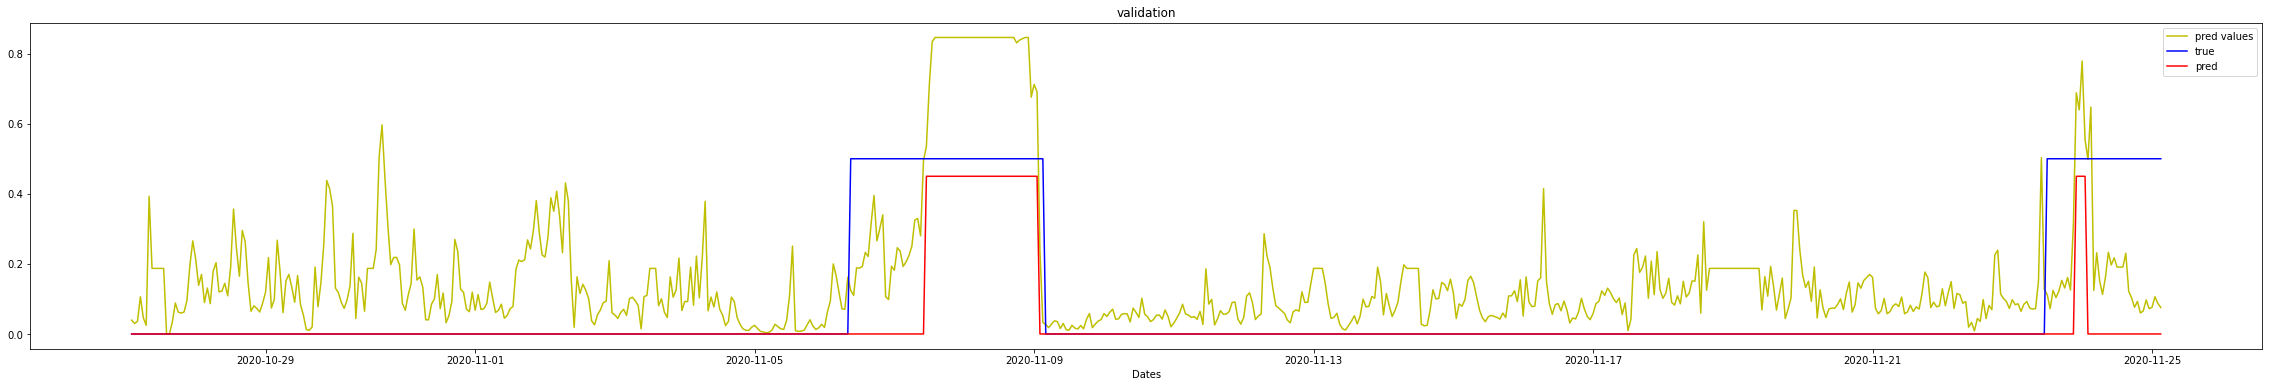

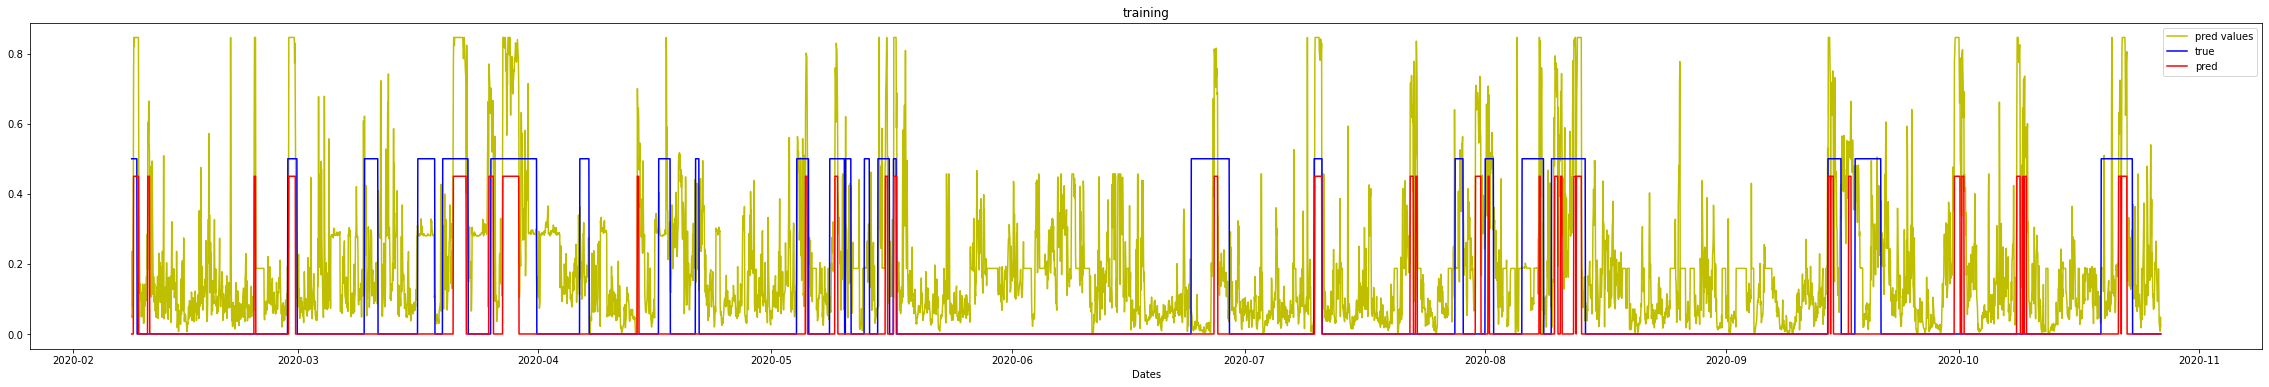

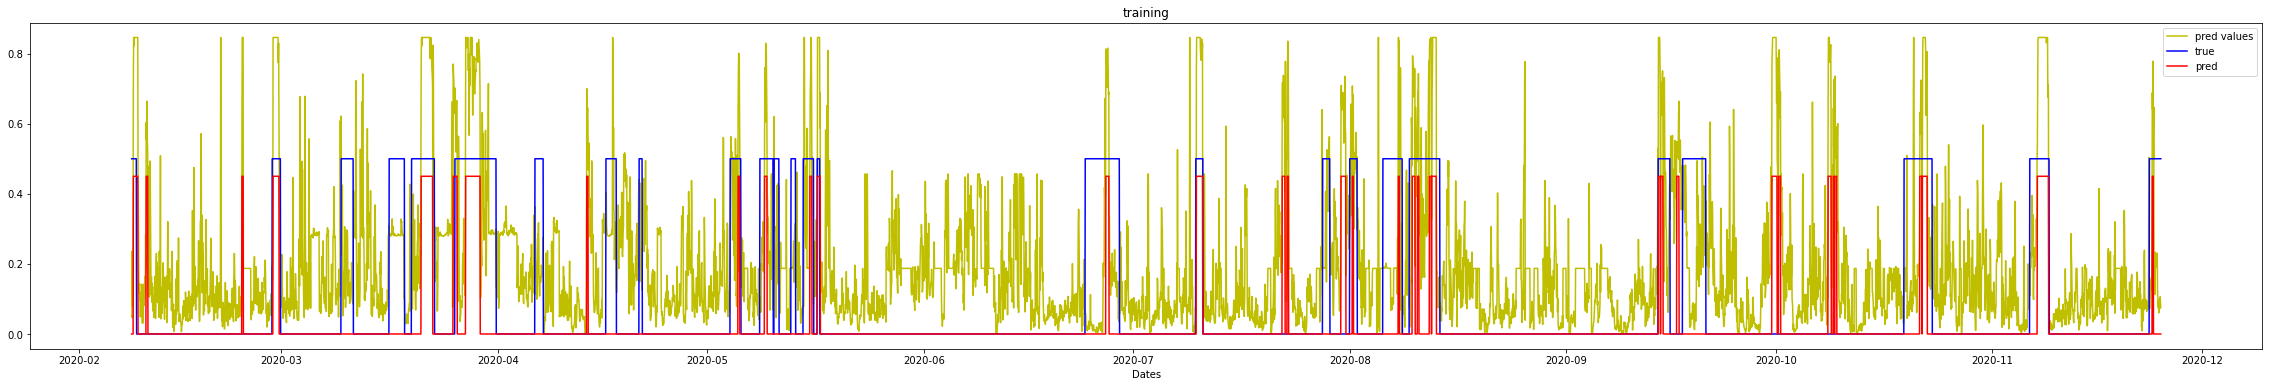

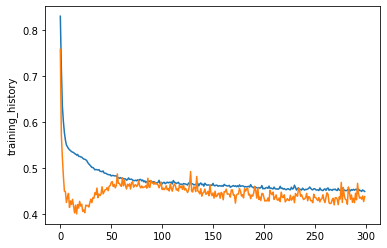

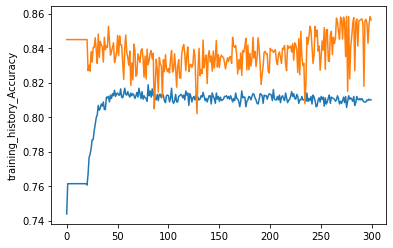

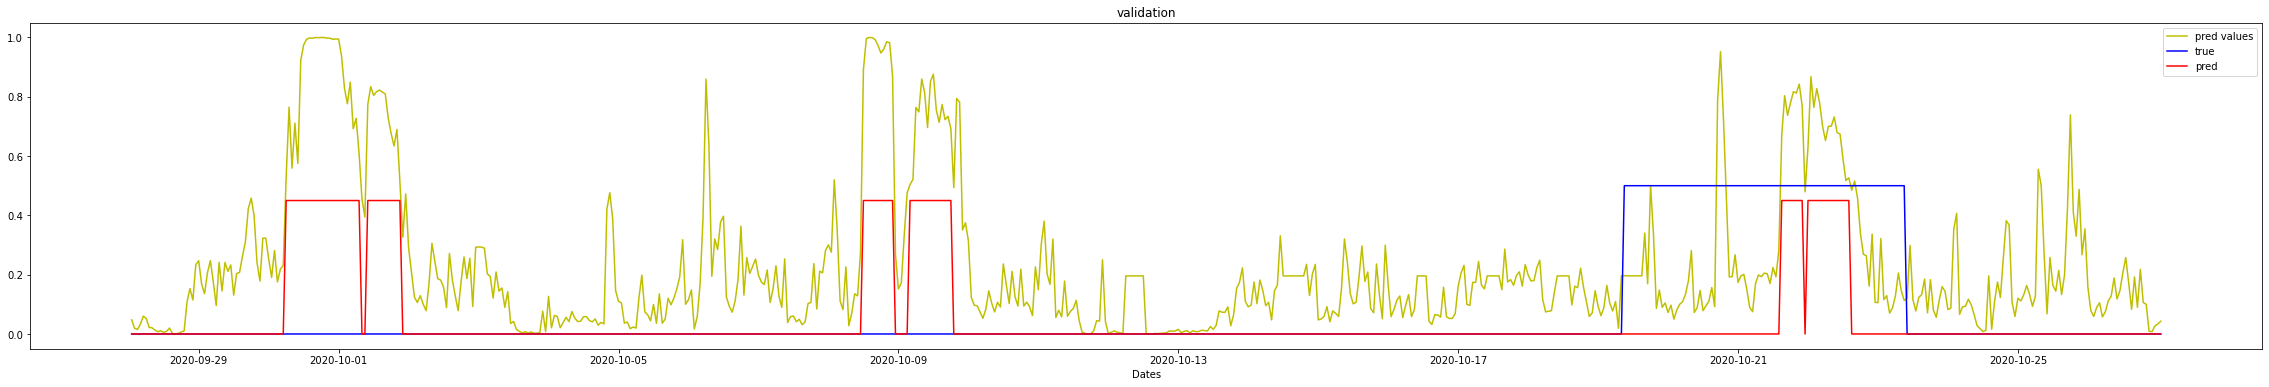

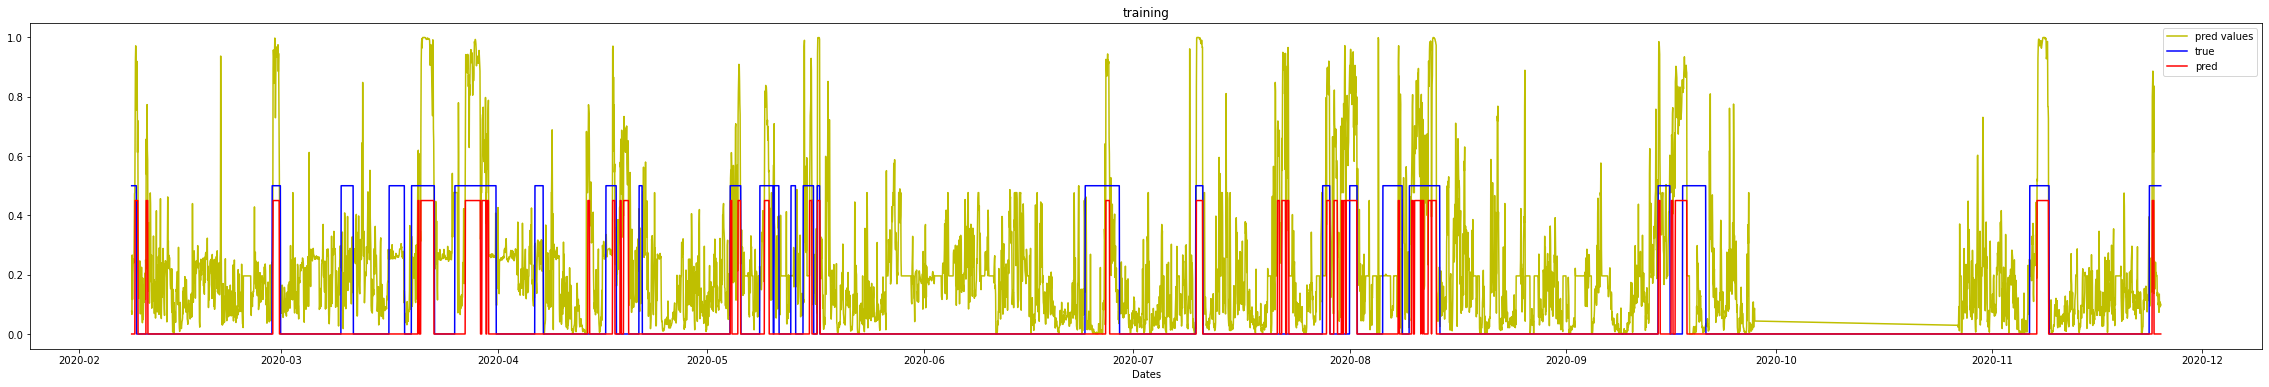

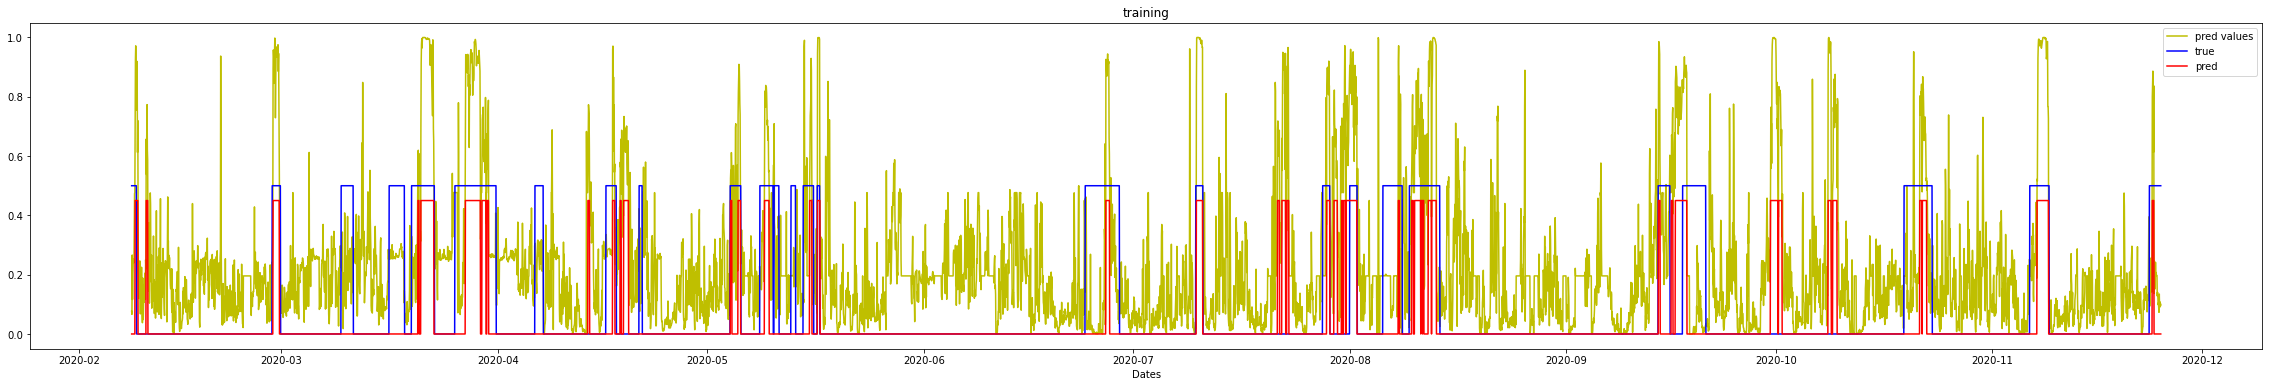

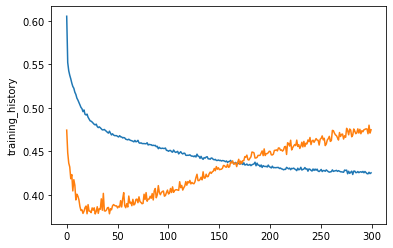

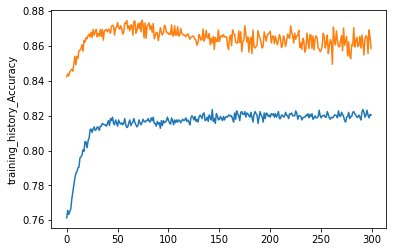

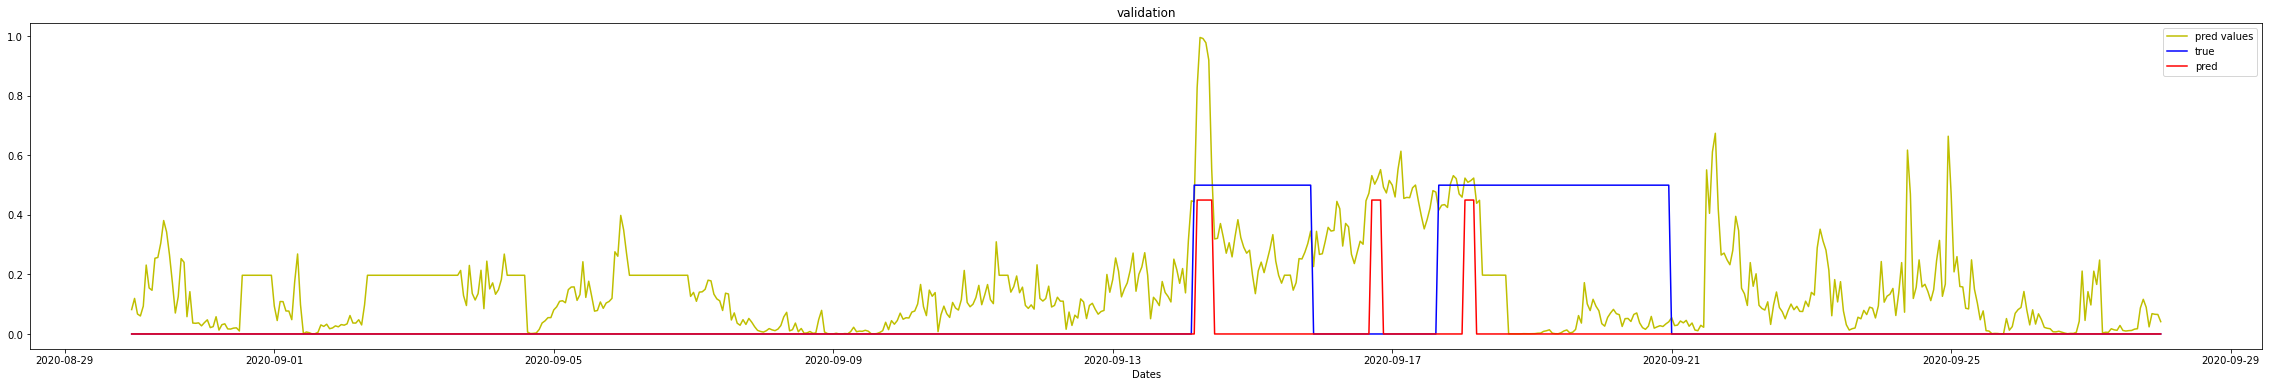

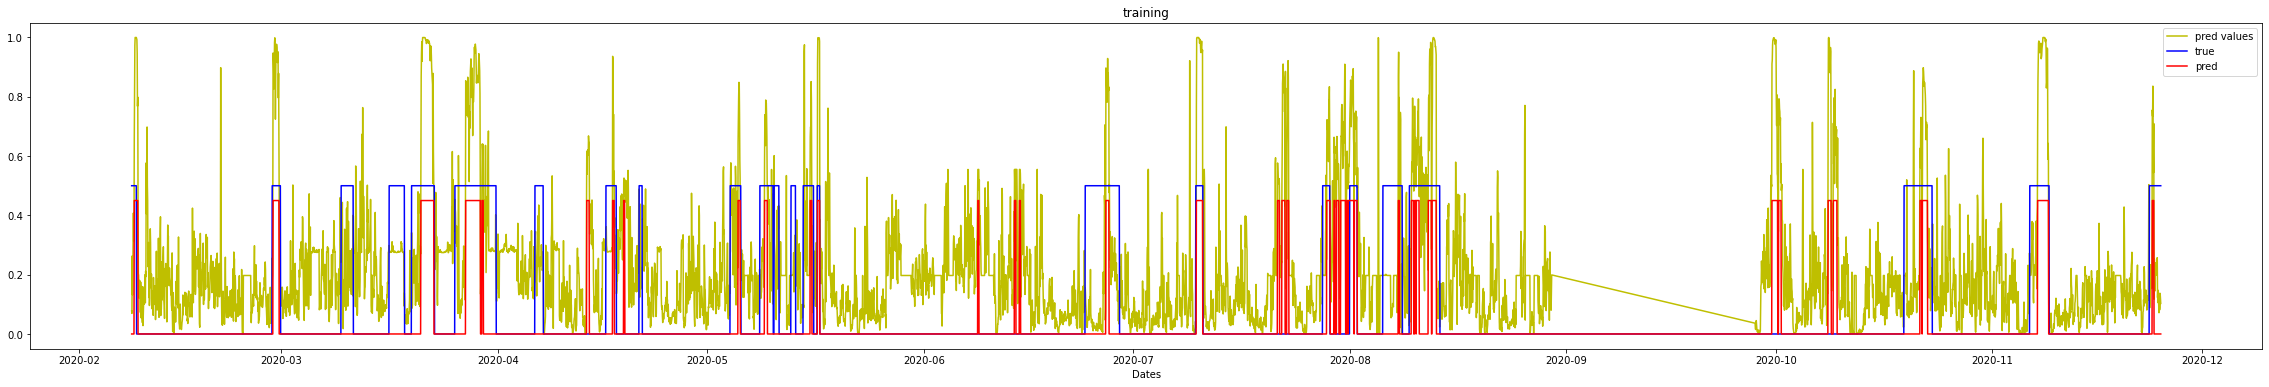

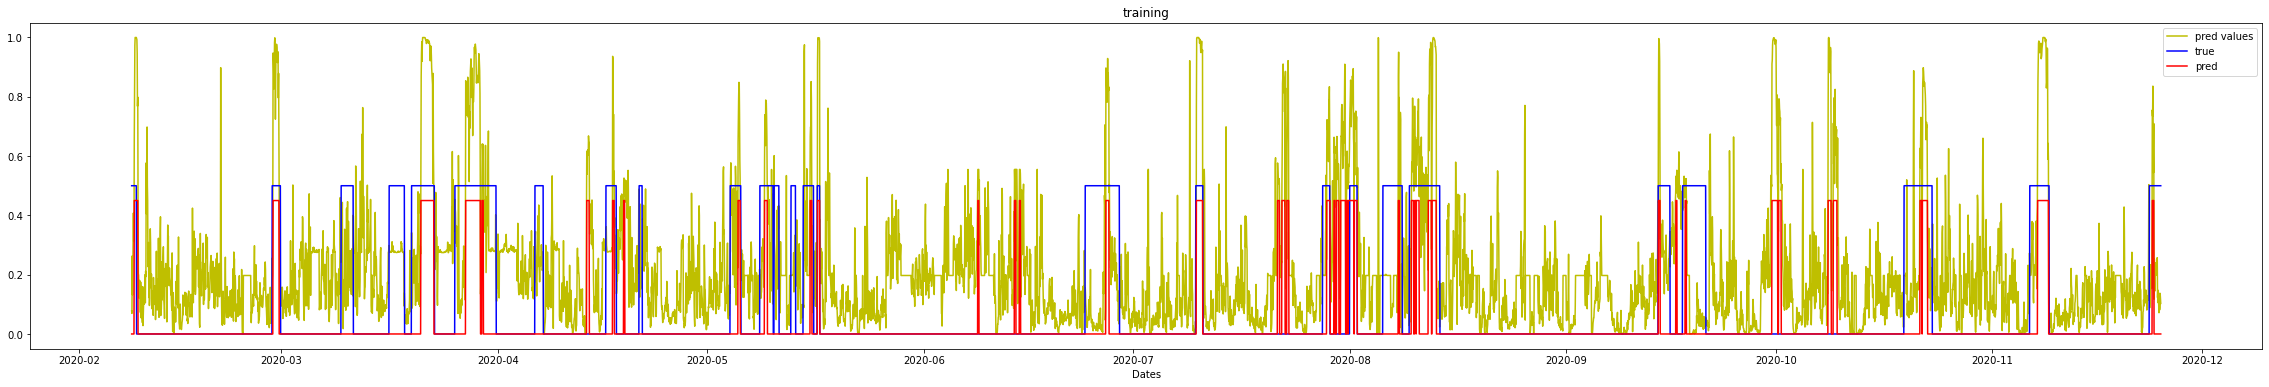

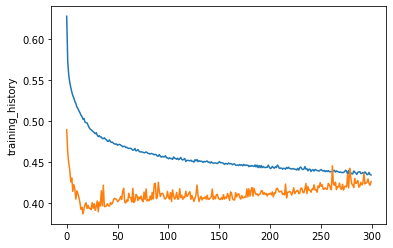

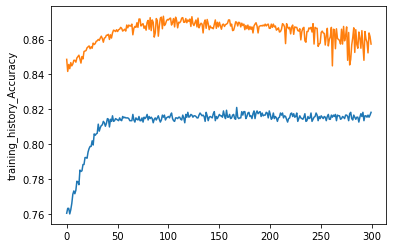

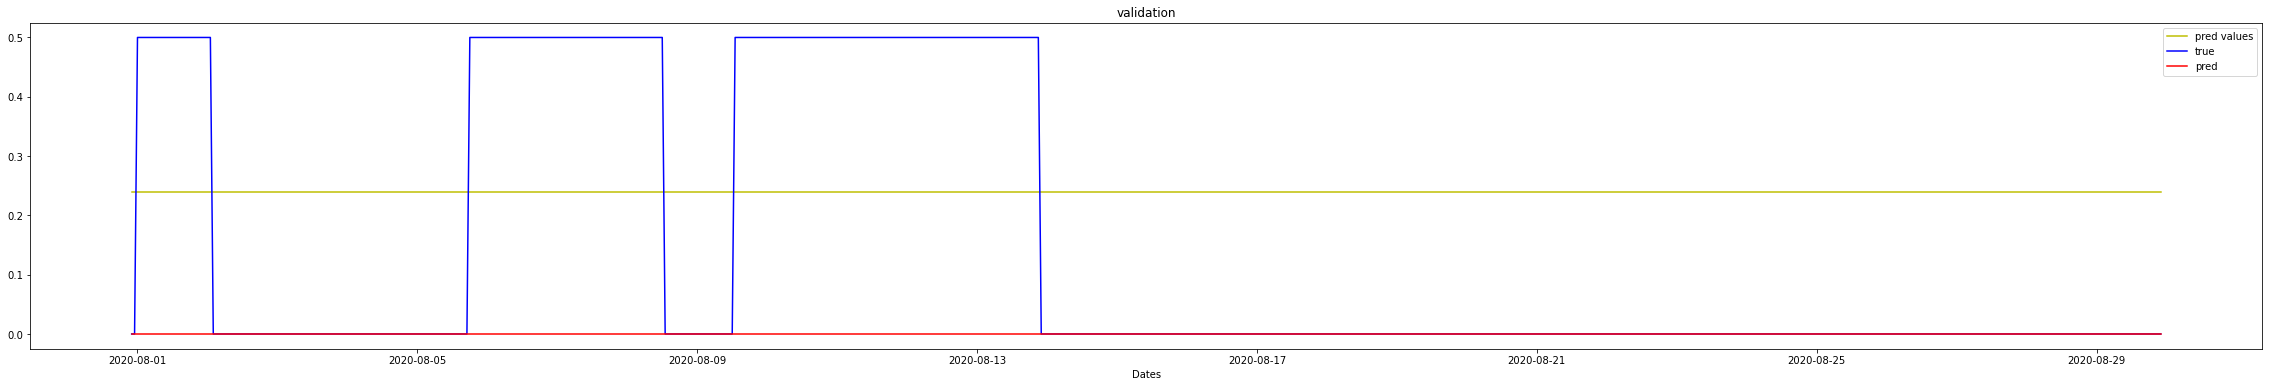

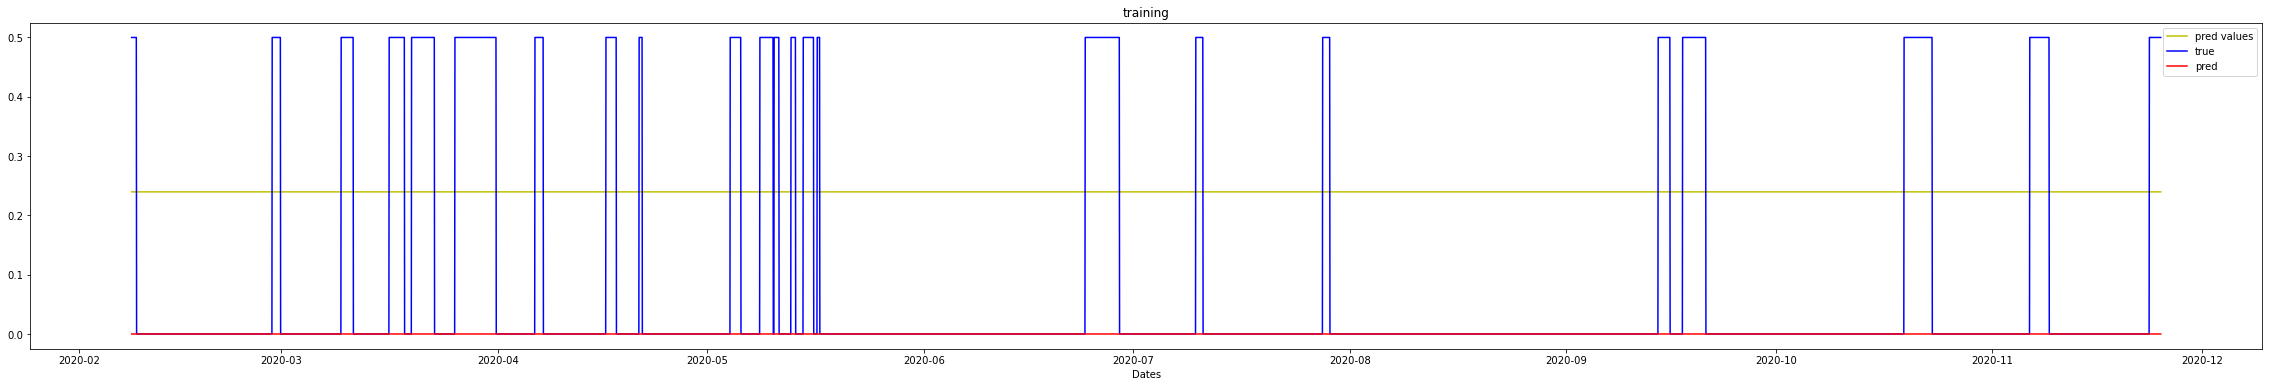

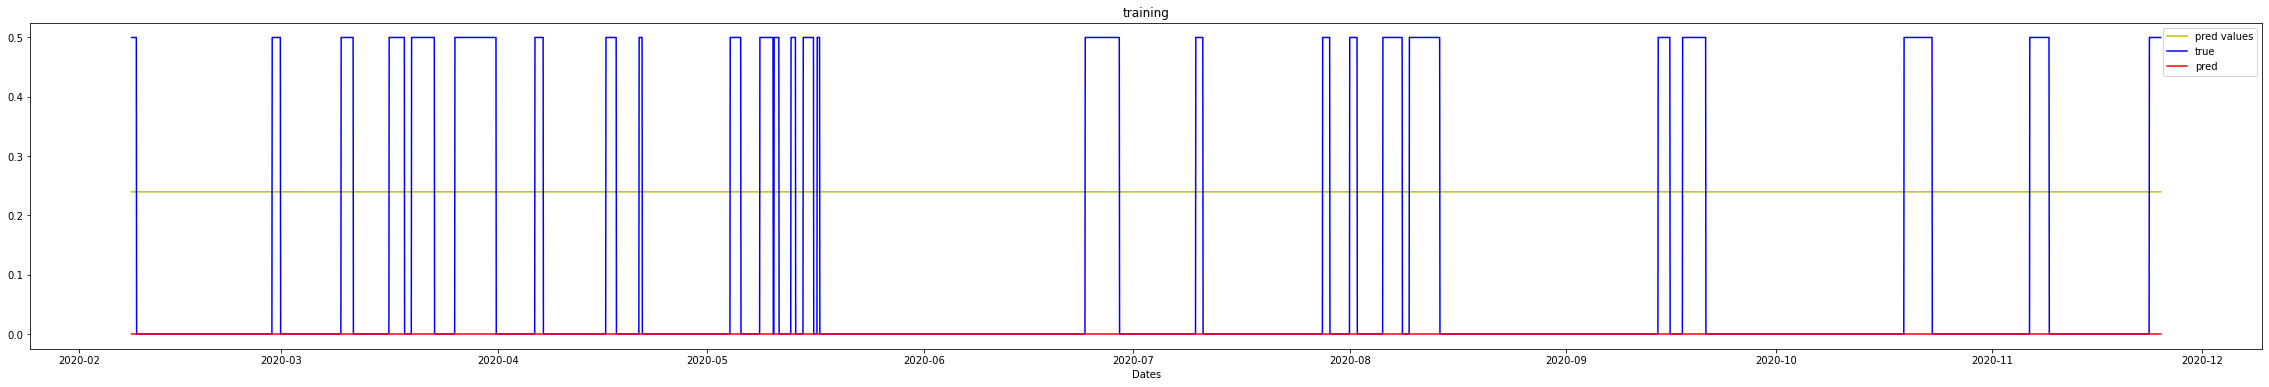

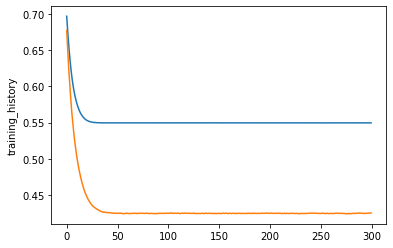

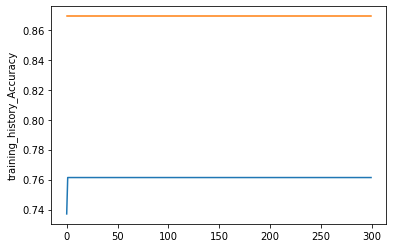

In [26]:


for index in [0,1,2,3]:
    
    print('Model: ', index)

    
    datafile_train = '/data/project/general/aerosolretriev/Jungfraujoch_data/NeuralNetwork/data_28_11_2022/train'+str(index)+'.h5'
    
    datafile_val = '/data/project/general/aerosolretriev/Jungfraujoch_data/NeuralNetwork/data_28_11_2022/val'+str(index)+'.h5'

    datafile = '/data/project/general/aerosolretriev/Jungfraujoch_data/NeuralNetwork/data_28_11_2022/data_all.h5'


    modelpath = '/data/project/general/aerosolretriev/Jungfraujoch_data/NeuralNetwork/data_28_11_2022/model_1'+str(index)

    
    
    df = pd.read_hdf(datafile, 'df') 
    df_output = df['sde_event']
    df_output = pd.DataFrame(data = df_output, columns = ['sde_event'])
    df_dates = df[['DateTimeUTC','sde_event','sde_event_nr']]
    df_input = df.drop(['sde_event_nr','sde_event','DateTimeUTC'],axis =1)

    df_input.reset_index(drop=True, inplace=True)

    df_output.reset_index(drop=True, inplace=True)

    df_dates.reset_index(drop=True, inplace=True)
    
    dvar_train = pd.read_hdf(datafile_train,key = 'dvar')
    dvar_val = pd.read_hdf(datafile_val,key = 'dvar')
    qoi_train = pd.read_hdf(datafile_train,key = 'qoi')
    qoi_val = pd.read_hdf(datafile_val,key = 'qoi')
    dates_train = pd.read_hdf(datafile_train,key = 'dates')
    dates_val = pd.read_hdf(datafile_val,key = 'dates')    
    history1=np.load(modelpath+'/my_history.npy',allow_pickle='TRUE').item()
    surr1 = keras.models.load_model(modelpath)
    # APPLY PREPROCESSING

    qoi_min = np.min(qoi_train, axis = 0)
    qoi_max = np.max(qoi_train, axis = 0)
    dvar_min = np.min(dvar_train, axis = 0)
    dvar_max = np.max(dvar_train, axis = 0)
    dvar_train_scaled = scaling(dvar_train, dvar_min, dvar_max, scale_min, scale_max)
    dvar_val_scaled = scaling(dvar_val, dvar_min, dvar_max, scale_min, scale_max)
    dvar_df_scaled = scaling(df_input, dvar_min, dvar_max, scale_min, scale_max)
    
    # USE TRAINED NETWORKS FOR PREDICTION
    qoi_val_pred = surr1.predict(np.asarray(dvar_val_scaled.values).astype('float32'))
    qoi_train_pred = surr1.predict(np.asarray(dvar_train_scaled.values).astype('float32'))
    qoi_df_pred = surr1.predict(np.asarray(dvar_df_scaled.values).astype('float32'))
    
    qoi_val_pred = pd.DataFrame(qoi_val_pred, columns = ['sde_event'])
    qoi_train_pred = pd.DataFrame(qoi_train_pred, columns = ['sde_event'])
    
    qoi_df_pred = pd.DataFrame(qoi_df_pred, columns = ['sde_event'])
   
    qoi_train_pred = compute_dust_events(qoi_train_pred)
    qoi_val_pred = compute_dust_events(qoi_val_pred)
    qoi_df_pred = compute_dust_events(qoi_df_pred)
    
    dates_val = number_noevents_dates(dates_val, 'sde_event_nr', 'nosde_event_nr')
    dates_train = number_noevents_dates(dates_train, 'sde_event_nr', 'nosde_event_nr')
    df_dates = number_noevents_dates(df_dates, 'sde_event_nr', 'nosde_event_nr')
    qoi_val_pred = number_noevents_data(qoi_val_pred, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')
    qoi_train_pred = number_noevents_data(qoi_train_pred, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')
    qoi_df_pred = number_noevents_data(qoi_df_pred, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

    
    
    print('Validation')
    result_val = metric_sde(dates_val, qoi_val_pred)
    print(result_val)
    result_val_acc = acc_prec_rec(result_val[4],result_val[5], result_val[6], result_val[7])
    
    print('Training')
    result_train = metric_sde(dates_train, qoi_train_pred)
    result_train_acc = acc_prec_rec(result_train[4],result_train[5], result_train[6], result_train[7])

    print('Whole dataframe')
    result_df = metric_sde(df_dates, qoi_df_pred)
    result_df_acc = acc_prec_rec(result_df[4],result_df[5], result_df[6], result_df[7])
    
    val_result = np.concatenate((result_val,np.array(result_val_acc[0:5])), axis =0)
    train_result = np.concatenate((result_train,np.array(result_train_acc[0:5])), axis =0)
    df_result = np.concatenate((result_df,np.array(result_df_acc[0:5])), axis =0)

    df_results['val_'+str(index)]= val_result
    df_results['train_'+str(index)] = train_result
    df_results['df_'+str(index)] = df_result
    df_results.rename(index = rowdict, inplace=True)
    df_results    
    
    
    
    
    
    # PLOT THE PREDICTIONS
    plt.figure(figsize = (40,6))
    plt.plot(dates_val['Dates'],qoi_val_pred['sde_event'],'y',label='pred values')
    plt.plot(dates_val['Dates'],qoi_val['sde_event']*0.5,'b',label = 'true')

    plt.plot(dates_val['Dates'],(qoi_val_pred['sde_event_predicted']*0.45),'r', label = 'pred')
    plt.xlabel('Dates')
    plt.title('validation')
    plt.legend()

    plt.figure(figsize = (40,6))
    plt.plot(dates_train['Dates'],qoi_train_pred['sde_event'],'y',label='pred values')
    plt.plot(dates_train['Dates'],qoi_train['sde_event']*0.5,'b',label = 'true')

    plt.plot(dates_train['Dates'],(qoi_train_pred['sde_event_predicted']*0.45),'r', label = 'pred')
    plt.title('training')
    plt.xlabel('Dates') 
    plt.legend()
    
    plt.figure(figsize = (40,6))
    plt.plot(df_dates['DateTimeUTC'],qoi_df_pred['sde_event'],'y',label='pred values')
    plt.plot(df_dates['DateTimeUTC'],df_output['sde_event']*0.5,'b',label = 'true')

    plt.plot(df_dates['DateTimeUTC'],(qoi_df_pred['sde_event_predicted']*0.45),'r', label = 'pred')
    plt.title('training')
    plt.xlabel('Dates')
    plt.legend()
    
    
    plt.figure()
    plt.plot(history1['loss'])
    plt.plot(history1['val_loss'])
    plt.ylabel('training_history')
    
    plt.figure()
    plt.plot(history1['accuracy'])
    plt.plot(history1['val_accuracy'])
    plt.ylabel('training_history_Accuracy')

In [27]:
qoi_df_pred['Ssde'] = 0*qoi_df_pred['sde_event']
qoi_df_pred['wsde']= 0*qoi_df_pred['sde_event']

In [28]:
for ind in qoi_df_pred.index:
    if qoi_df_pred['sde_event_predicted'].loc[ind]==1.0:
        if qoi_df_pred['sde_event'].loc[ind]>0.75:
            print(ind)
            print('test')
            qoi_df_pred['Ssde'].loc[ind]=1.0
        elif qoi_df_pred['sde_event'].loc[ind]>0.5 and qoi_df_pred['sde_event'].loc[ind]<=0.75:
            qoi_df_pred['wsde'].loc[ind] = 1.0
            print(ind)
            print('te')

In [29]:
qoi_df_pred.describe()

sde_event  sde_event_predicted  nosde_event_predicted_nr  \
count  6.974000e+03               6974.0                    6974.0   
mean   2.396394e-01                  0.0                       1.0   
std    7.466785e-15                  0.0                       0.0   
min    2.396394e-01                  0.0                       1.0   
25%    2.396394e-01                  0.0                       1.0   
50%    2.396394e-01                  0.0                       1.0   
75%    2.396394e-01                  0.0                       1.0   
max    2.396394e-01                  0.0                       1.0   

       sde_event_predicted_nr    Ssde    wsde  
count                  6974.0  6974.0  6974.0  
mean                      0.0     0.0     0.0  
std                       0.0     0.0     0.0  
min                       0.0     0.0     0.0  
25%                       0.0     0.0     0.0  
50%                       0.0     0.0     0.0  
75%                       0.0     0.0     0.0  
max                       0.0     0.0     0.0

<AxesSubplot:>

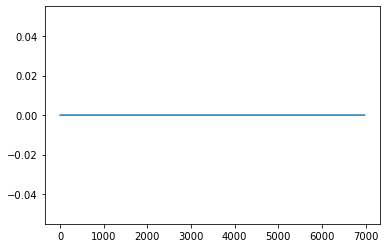

In [30]:
qoi_df_pred['Ssde'].plot()

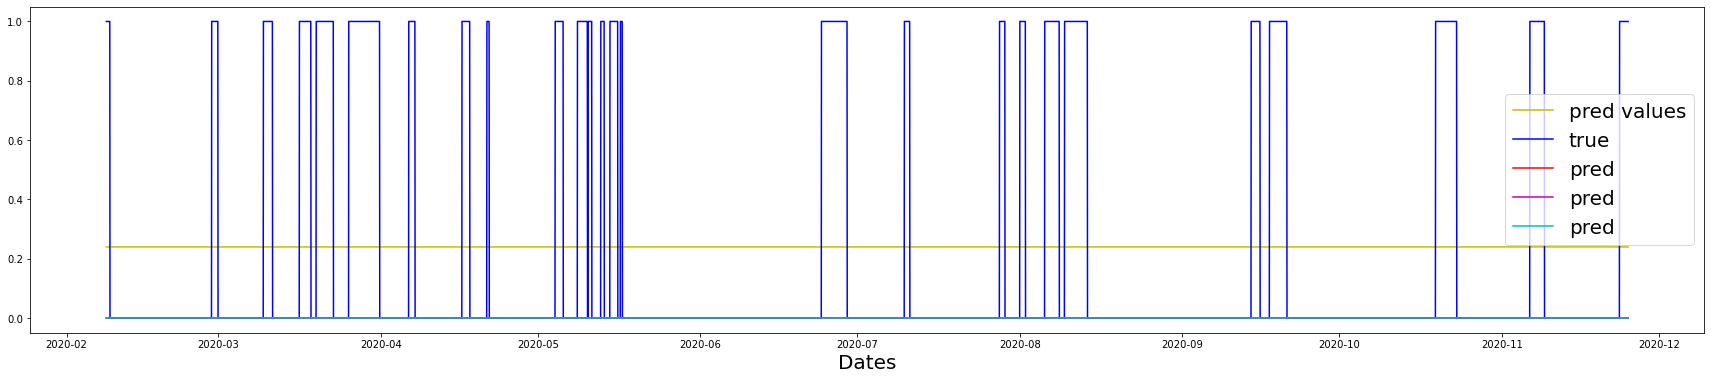

In [31]:
 # PLOT THE PREDICTIONS

plt.figure(figsize = (30,6))
plt.plot(df_dates['DateTimeUTC'],qoi_df_pred['sde_event'],'y',label='pred values')
plt.plot(df_dates['DateTimeUTC'],df_output['sde_event'],'b',label = 'true')

plt.plot(df_dates['DateTimeUTC'],(qoi_df_pred['sde_event_predicted']*0.75),'r', label = 'pred')
plt.plot(df_dates['DateTimeUTC'],(qoi_df_pred['Ssde']*0.5),'m', label = 'pred')
plt.plot(df_dates['DateTimeUTC'],(qoi_df_pred['wsde']*0.25),'c', label = 'pred')

plt.xlabel('Dates', fontsize = 20)
plt.legend(fontsize = 20)



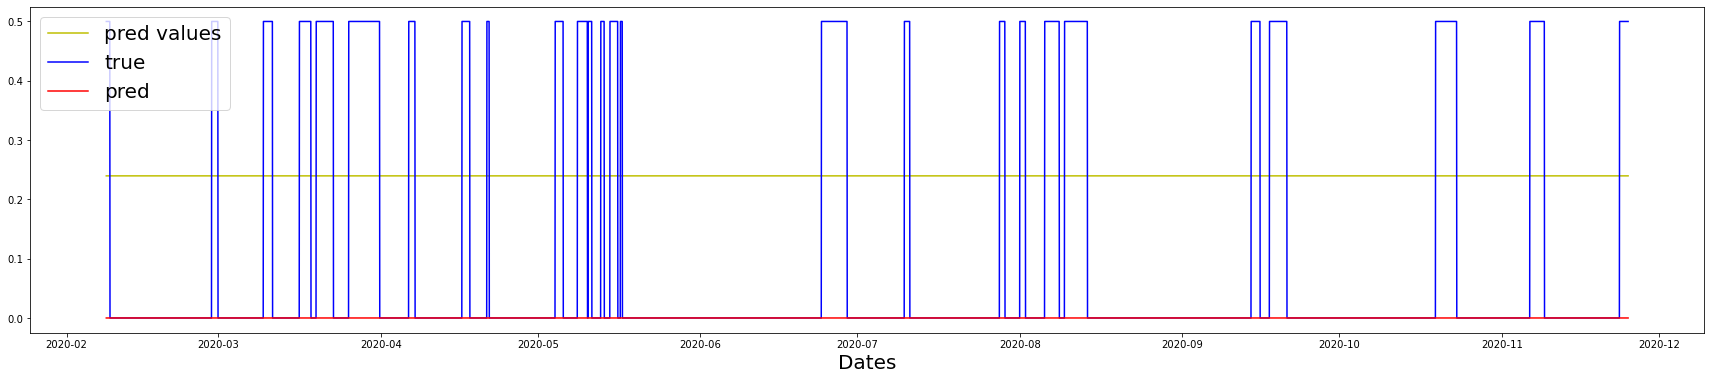

In [32]:
 # PLOT THE PREDICTIONS

plt.figure(figsize = (30,6))
plt.plot(df_dates['DateTimeUTC'],qoi_df_pred['sde_event'],'y',label='pred values')
plt.plot(df_dates['DateTimeUTC'],df_output['sde_event']*0.5,'b',label = 'true')

plt.plot(df_dates['DateTimeUTC'],(qoi_df_pred['sde_event_predicted']*0.45),'r', label = 'pred')

plt.xlabel('Dates', fontsize = 20)
plt.legend(fontsize = 20)



Text(0, 0.5, 'training_history')

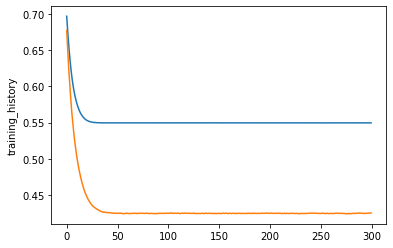

In [33]:
plt.figure()
plt.plot(history1['loss'])
plt.plot(history1['val_loss'])
plt.ylabel('training_history')

Text(0, 0.5, 'training_history')

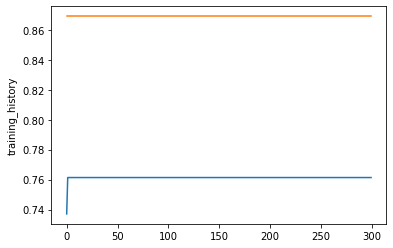

In [34]:
    plt.figure()
    plt.plot(history1['accuracy'])
    plt.plot(history1['val_accuracy'])
    plt.ylabel('training_history')

In [35]:
history1

{'loss': [0.6969209409054661,
  0.6756441194956565,
  0.6569455865390327,
  0.6405129477682429,
  0.6261997576823382,
  0.6139428447928537,
  0.603607099033399,
  0.594897416878347,
  0.5876053729122248,
  0.5814223795882655,
  0.5762366585163644,
  0.5717128726404663,
  0.5679022876073152,
  0.5646244110624046,
  0.5619505833378854,
  0.5596790051660399,
  0.5577952986768182,
  0.5561876417276822,
  0.5548409778494114,
  0.5537607575017085,
  0.552899387618483,
  0.5522184239169636,
  0.5516107135355026,
  0.5511443947462336,
  0.5507702761876315,
  0.550499106453374,
  0.5502632922997651,
  0.5501064193399944,
  0.549971107218449,
  0.5498749490625934,
  0.5497967329168353,
  0.5497327887345133,
  0.5496543484953877,
  0.5496189810340085,
  0.5496090947814726,
  0.5495750416623407,
  0.549598407769158,
  0.5495708060003763,
  0.5495709053293107,
  0.5495632193100857,
  0.5495462595184901,
  0.5495599145943144,
  0.549568159452044,
  0.5495432561150081,
  0.5495465313480556,
  0.54954

In [36]:
df_results.columns

Index(['val_0', 'train_0', 'df_0', 'val_1', 'train_1', 'df_1', 'val_2',
       'train_2', 'df_2', 'val_3', 'train_3', 'df_3'],
      dtype='object')

In [37]:
val_col = [x for x in df_results.columns if 'val' in x]
train_col = [x for x in df_results.columns if 'train' in x]
df_col = [x for x in df_results.columns if 'df' in x]
val_col

['val_0', 'val_1', 'val_2', 'val_3']

In [38]:
df_col

['df_0', 'df_1', 'df_2', 'df_3']

In [39]:
df_results['average_val']=df_results[val_col].mean(axis =1)
df_results['average_train']=df_results[train_col].mean(axis =1)
df_results['average_df']=df_results[df_col].mean(axis =1)



In [40]:
df_results['std_val']=df_results[val_col].std(axis =1)
df_results['std_train']=df_results[train_col].std(axis =1)
df_results['std_df']=df_results[df_col].std(axis =1)



In [41]:
df_results

val_0    train_0       df_0     val_1    train_1       df_1  \
#sde_truth    2.000000  24.000000  26.000000  1.000000  25.000000  26.000000   
#nosde_truth  2.000000  24.000000  25.000000  2.000000  24.000000  25.000000   
#sde_pred     2.000000  33.000000  35.000000  6.000000  39.000000  45.000000   
#nosde_pred   3.000000  34.000000  36.000000  7.000000  40.000000  46.000000   
TP            2.000000  15.000000  17.000000  1.000000  19.000000  20.000000   
FN            0.000000   9.000000   9.000000  0.000000   6.000000   6.000000   
TN            1.000000  16.000000  17.000000  1.000000  17.000000  17.000000   
FP            1.000000   8.000000   8.000000  1.000000   7.000000   8.000000   
accuracy      0.750000   0.645833   0.666667  0.666667   0.734694   0.725490   
precision     0.666667   0.652174   0.680000  0.500000   0.730769   0.714286   
recall        1.000000   0.625000   0.653846  1.000000   0.760000   0.769231   
specificity   0.500000   0.666667   0.680000  0.500000   0.708333   0.680000   
F1            0.800000   0.638298   0.666667  0.666667   0.745098   0.740741   

                 val_2    train_2       df_2     val_3    train_3       df_3  \
#sde_truth    2.000000  24.000000  26.000000  3.000000  23.000000  26.000000   
#nosde_truth  3.000000  23.000000  25.000000  4.000000  22.000000  25.000000   
#sde_pred     3.000000  41.000000  44.000000  0.000000   0.000000   0.000000   
#nosde_pred   4.000000  42.000000  45.000000  1.000000   1.000000   1.000000   
TP            2.000000  18.000000  20.000000  0.000000   0.000000   0.000000   
FN            0.000000   6.000000   6.000000  3.000000  23.000000  26.000000   
TN            1.000000  16.000000  17.000000  4.000000  22.000000  25.000000   
FP            2.000000   7.000000   8.000000  0.000000   0.000000   0.000000   
accuracy      0.600000   0.723404   0.725490  0.571429   0.488889   0.490196   
precision     0.500000   0.720000   0.714286  0.000000   0.000000   0.000000   
recall        1.000000   0.750000   0.769231  0.000000   0.000000   0.000000   
specificity   0.333333   0.695652   0.680000  1.000000   1.000000   1.000000   
F1            0.666667   0.734694   0.740741  0.000000   0.000000   0.000000   

              average_val  average_train  average_df   std_val  std_train  \
#sde_truth       2.000000      24.000000   26.000000  0.816497   0.816497   
#nosde_truth     2.750000      23.250000   25.000000  0.957427   0.957427   
#sde_pred        2.750000      28.250000   31.000000  2.500000  19.137659   
#nosde_pred      3.750000      29.250000   32.000000  2.500000  19.137659   
TP               1.250000      13.000000   14.250000  0.957427   8.831761   
FN               0.750000      11.000000   11.750000  1.500000   8.124038   
TN               1.750000      17.750000   19.000000  1.500000   2.872281   
FP               1.000000       5.500000    6.000000  0.816497   3.696846   
accuracy         0.647024       0.648205    0.651961  0.079406   0.113317   
precision        0.416667       0.525736    0.527143  0.288675   0.352213   
recall           0.750000       0.533750    0.548077  0.500000   0.361095   
specificity      0.583333       0.767663    0.760000  0.288675   0.155870   
F1               0.533333       0.529522    0.537037  0.361068   0.356274   

                 std_df  
#sde_truth     0.000000  
#nosde_truth   0.000000  
#sde_pred     21.150256  
#nosde_pred   21.150256  
TP             9.604686  
FN             9.604686  
TN             4.000000  
FP             4.000000  
accuracy       0.111351  
precision      0.351800  
recall         0.369411  
specificity    0.160000  
F1             0.359724

In [42]:
df_results[df_col]

df_0       df_1       df_2       df_3
#sde_truth    26.000000  26.000000  26.000000  26.000000
#nosde_truth  25.000000  25.000000  25.000000  25.000000
#sde_pred     35.000000  45.000000  44.000000   0.000000
#nosde_pred   36.000000  46.000000  45.000000   1.000000
TP            17.000000  20.000000  20.000000   0.000000
FN             9.000000   6.000000   6.000000  26.000000
TN            17.000000  17.000000  17.000000  25.000000
FP             8.000000   8.000000   8.000000   0.000000
accuracy       0.666667   0.725490   0.725490   0.490196
precision      0.680000   0.714286   0.714286   0.000000
recall         0.653846   0.769231   0.769231   0.000000
specificity    0.680000   0.680000   0.680000   1.000000
F1             0.666667   0.740741   0.740741   0.000000

In [19]:
df_results[val_col].loc['accuracy']

val_0    0.800000
val_1    0.727273
val_2    0.647059
val_3    0.625000
Name: accuracy, dtype: float64

In [20]:
df_results[val_col].loc['accuracy']

val_0    0.800000
val_1    0.727273
val_2    0.647059
val_3    0.625000
Name: accuracy, dtype: float64

In [21]:
surr1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 24)                600       
                                                                 
 gaussian_noise (GaussianNoi  (None, 24)               0         
 se)                                                             
                                                                 
 dense_3 (Dense)             (None, 6)                 150       
                                                                 
 dense_4 (Dense)             (None, 6)                 42        
                                                                 
 dense_5 (Dense)             (None, 6)                 42        
                                                                 
 dense_6 (Dense)             (None, 1)                 7         
                                                      

In [22]:

datafile = '/data/project/general/aerosolretriev/Jungfraujoch_data/NeuralNetwork/data_28_11_2022/data_all.h5'


modelpath0 = '/data/project/general/aerosolretriev/Jungfraujoch_data/NeuralNetwork/data_28_11_2022/model_10'
modelpath1 = '/data/project/general/aerosolretriev/Jungfraujoch_data/NeuralNetwork/data_28_11_2022/model_11'
modelpath2 = '/data/project/general/aerosolretriev/Jungfraujoch_data/NeuralNetwork/data_28_11_2022/model_12'
modelpath3 = '/data/project/general/aerosolretriev/Jungfraujoch_data/NeuralNetwork/data_28_11_2022/model_13'
modelpath4 = '/data/project/general/aerosolretriev/Jungfraujoch_data/NeuralNetwork/data_28_11_2022/model_14'
modelpath5 = '/data/project/general/aerosolretriev/Jungfraujoch_data/NeuralNetwork/data_28_11_2022/model_15'
modelpath6 = '/data/project/general/aerosolretriev/Jungfraujoch_data/NeuralNetwork/data_28_11_2022/model_16'
modelpath7 = '/data/project/general/aerosolretriev/Jungfraujoch_data/NeuralNetwork/data_28_11_2022/model_17'
modelpath8 = '/data/project/general/aerosolretriev/Jungfraujoch_data/NeuralNetwork/data_28_11_2022/model_18'
modelpath9 = '/data/project/general/aerosolretriev/Jungfraujoch_data/NeuralNetwork/data_28_11_2022/model_19'







df = pd.read_hdf(datafile, 'df') 
df_output = df['sde_event']
df_output = pd.DataFrame(data = df_output, columns = ['sde_event'])
df_dates = df[['DateTimeUTC','sde_event','sde_event_nr']]
df_input = df.drop(['sde_event_nr','sde_event','DateTimeUTC'],axis =1)

df_input.reset_index(drop=True, inplace=True)

df_output.reset_index(drop=True, inplace=True)

df_dates.reset_index(drop=True, inplace=True)

surr0 = keras.models.load_model(modelpath0)
surr1 = keras.models.load_model(modelpath1)    
surr2 = keras.models.load_model(modelpath2)    
surr3 = keras.models.load_model(modelpath3)    
surr4 = keras.models.load_model(modelpath4)
surr5 = keras.models.load_model(modelpath5)
surr6 = keras.models.load_model(modelpath6) 
surr7 = keras.models.load_model(modelpath7)
surr8 = keras.models.load_model(modelpath8)   
surr9 = keras.models.load_model(modelpath9) 
# APPLY PREPROCESSING

qoi_min = np.min(qoi_train, axis = 0)
qoi_max = np.max(qoi_train, axis = 0)
dvar_min = np.min(dvar_train, axis = 0)
dvar_max = np.max(dvar_train, axis = 0)
dvar_df_scaled = scaling(df_input, dvar_min, dvar_max, scale_min, scale_max)

# USE TRAINED NETWORKS FOR PREDICTION
qoi_df_pred0 = surr0.predict(np.asarray(dvar_df_scaled.values).astype('float32'))
qoi_df_pred1 = surr1.predict(np.asarray(dvar_df_scaled.values).astype('float32'))

qoi_df_pred2 = surr2.predict(np.asarray(dvar_df_scaled.values).astype('float32'))

qoi_df_pred3 = surr3.predict(np.asarray(dvar_df_scaled.values).astype('float32'))

qoi_df_pred4 = surr4.predict(np.asarray(dvar_df_scaled.values).astype('float32'))

qoi_df_pred5 = surr5.predict(np.asarray(dvar_df_scaled.values).astype('float32'))

qoi_df_pred6 = surr6.predict(np.asarray(dvar_df_scaled.values).astype('float32'))

qoi_df_pred7 = surr7.predict(np.asarray(dvar_df_scaled.values).astype('float32'))
qoi_df_pred8 = surr8.predict(np.asarray(dvar_df_scaled.values).astype('float32'))
qoi_df_pred9 = surr9.predict(np.asarray(dvar_df_scaled.values).astype('float32'))




qoi_df_pred_new = (qoi_df_pred0+qoi_df_pred1+qoi_df_pred2+qoi_df_pred3+qoi_df_pred4+qoi_df_pred5+qoi_df_pred6+qoi_df_pred7+qoi_df_pred8+qoi_df_pred9)/10.

#qoi_df_pred_new = (qoi_df_pred0+qoi_df_pred1+qoi_df_pred3+qoi_df_pred4+qoi_df_pred6+qoi_df_pred7+qoi_df_pred8+qoi_df_pred9)/8.



qoi_df_pred_new = pd.DataFrame(qoi_df_pred_new, columns = ['sde_event'])

qoi_df_pred_new = compute_dust_events(qoi_df_pred_new)

df_dates = number_noevents_dates(df_dates, 'sde_event_nr', 'nosde_event_nr')
qoi_df_pred_new = number_noevents_data(qoi_df_pred_new, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

'''
qoi_df_pred0 = pd.DataFrame(qoi_df_pred0, columns = ['sde_event'])
qoi_df_pred0 = compute_dust_events(qoi_df_pred0)
qoi_df_pred0 = number_noevents_data(qoi_df_pred0, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

qoi_df_pred1 = pd.DataFrame(qoi_df_pred1, columns = ['sde_event'])
qoi_df_pred1 = compute_dust_events(qoi_df_pred1)
qoi_df_pred1 = number_noevents_data(qoi_df_pred1, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

qoi_df_pred2 = pd.DataFrame(qoi_df_pred2, columns = ['sde_event'])
qoi_df_pred2 = compute_dust_events(qoi_df_pred2)
qoi_df_pred2 = number_noevents_data(qoi_df_pred2, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

qoi_df_pred3 = pd.DataFrame(qoi_df_pred3, columns = ['sde_event'])
qoi_df_pred3 = compute_dust_events(qoi_df_pred3)
qoi_df_pred3 = number_noevents_data(qoi_df_pred3, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

qoi_df_pred4 = pd.DataFrame(qoi_df_pred4, columns = ['sde_event'])
qoi_df_pred4 = compute_dust_events(qoi_df_pred4)
qoi_df_pred4 = number_noevents_data(qoi_df_pred4, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

qoi_df_pred5 = pd.DataFrame(qoi_df_pred5, columns = ['sde_event'])
qoi_df_pred5 = compute_dust_events(qoi_df_pred5)
qoi_df_pred5 = number_noevents_data(qoi_df_pred5, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

qoi_df_pred6 = pd.DataFrame(qoi_df_pred6, columns = ['sde_event'])
qoi_df_pred6 = compute_dust_events(qoi_df_pred6)
qoi_df_pred6 = number_noevents_data(qoi_df_pred6, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

qoi_df_pred7 = pd.DataFrame(qoi_df_pred7, columns = ['sde_event'])
qoi_df_pred7 = compute_dust_events(qoi_df_pred7)
qoi_df_pred7 = number_noevents_data(qoi_df_pred7, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

qoi_df_pred8 = pd.DataFrame(qoi_df_pred8, columns = ['sde_event'])
qoi_df_pred8 = compute_dust_events(qoi_df_pred8)
qoi_df_pred8 = number_noevents_data(qoi_df_pred8, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

qoi_df_pred9 = pd.DataFrame(qoi_df_pred9, columns = ['sde_event'])
qoi_df_pred9 = compute_dust_events(qoi_df_pred9)
qoi_df_pred9 = number_noevents_data(qoi_df_pred9, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')


qoi_df_pred_new_test = qoi_df_pred_new.copy()
qoi_df_pred_new = (qoi_df_pred0+qoi_df_pred1+qoi_df_pred2+qoi_df_pred3+qoi_df_pred4+qoi_df_pred5+qoi_df_pred6+qoi_df_pred7+qoi_df_pred8+qoi_df_pred9)/10.
'''




print('Whole dataframe')
result_df_new = metric_sde(df_dates, qoi_df_pred_new)
result_df_acc_new = acc_prec_rec(result_df_new[4],result_df_new[5], result_df_new[6], result_df_new[7])

df_result_new = np.concatenate((result_df_new,np.array(result_df_acc_new[0:5])), axis =0)

df_results['df_total'] = df_result_new
df_results.rename(index = rowdict, inplace=True)
df_results    





# PLOT THE PREDICTIONS

plt.figure(figsize = (40,6))
plt.plot(df_dates['DateTimeUTC'],qoi_df_pred_new['sde_event'],'y',label='pred values')
plt.plot(df_dates['DateTimeUTC'],df_output['sde_event']*0.5,'b',label = 'true')

plt.plot(df_dates['DateTimeUTC'],(qoi_df_pred_new['sde_event_predicted']*0.45),'r', label = 'pred')
plt.title('training')
plt.xlabel('Dates')
plt.legend()




FileNotFoundError: File /Users/boiger_r/switchdrive/Arbeit/Aerosol/Dust_event_classification/data/data_ML_15_09_2022_50/data/data.h5 does not exist

In [ ]:
#(qoi_df_pred_new['sde_event']-qoi_df_pred_new_test['sde_event']).sum()

In [ ]:


for index in [1]:
    
    print('Model: ', index)

    
    datafile_train = '/data/project/general/aerosolretriev/Jungfraujoch_data/NeuralNetwork/data_24_11_2022/train'+str(index)+'.h5'
   
    datafile_val = '/data/project/general/aerosolretriev/Jungfraujoch_data/NeuralNetwork/data_24_11_2022/val'+str(index)+'.h5'

    datafile = '/data/project/general/aerosolretriev/Jungfraujoch_data/NeuralNetwork/data_24_11_2022/data_all.h5'


    modelpath = '/data/project/general/aerosolretriev/Jungfraujoch_data/NeuralNetwork/data_24_11_2022/model_'+str(index)


    
    
    df = pd.read_hdf(datafile, 'df') 
    df_output = df['sde_event']
    df_output = pd.DataFrame(data = df_output, columns = ['sde_event'])
    df_dates = df[['DateTimeUTC','sde_event','sde_event_nr']]
    df_input = df.drop(['sde_event_nr','sde_event','DateTimeUTC'],axis =1)

    df_input.reset_index(drop=True, inplace=True)

    df_output.reset_index(drop=True, inplace=True)

    df_dates.reset_index(drop=True, inplace=True)
    
    dvar_train = pd.read_hdf(datafile_train,key = 'dvar')
    dvar_val = pd.read_hdf(datafile_val,key = 'dvar')
    qoi_train = pd.read_hdf(datafile_train,key = 'qoi')
    qoi_val = pd.read_hdf(datafile_val,key = 'qoi')
    dates_train = pd.read_hdf(datafile_train,key = 'dates')
    dates_val = pd.read_hdf(datafile_val,key = 'dates')    
    history1=np.load(modelpath+'/my_history.npy',allow_pickle='TRUE').item()
    surr1 = keras.models.load_model(modelpath)
    # APPLY PREPROCESSING

    qoi_min = np.min(qoi_train, axis = 0)
    qoi_max = np.max(qoi_train, axis = 0)
    dvar_min = np.min(dvar_train, axis = 0)
    dvar_max = np.max(dvar_train, axis = 0)
    dvar_train_scaled = scaling(dvar_train, dvar_min, dvar_max, scale_min, scale_max)
    dvar_val_scaled = scaling(dvar_val, dvar_min, dvar_max, scale_min, scale_max)
    dvar_df_scaled = scaling(df_input, dvar_min, dvar_max, scale_min, scale_max)
    
    # USE TRAINED NETWORKS FOR PREDICTION
    qoi_val_pred = surr1.predict(np.asarray(dvar_val_scaled.values).astype('float32'))
    qoi_train_pred = surr1.predict(np.asarray(dvar_train_scaled.values).astype('float32'))
    qoi_df_pred = surr1.predict(np.asarray(dvar_df_scaled.values).astype('float32'))
    
    qoi_val_pred = pd.DataFrame(qoi_val_pred, columns = ['sde_event'])
    qoi_train_pred = pd.DataFrame(qoi_train_pred, columns = ['sde_event'])
    
    qoi_df_pred = pd.DataFrame(qoi_df_pred, columns = ['sde_event'])
   
    qoi_train_pred = compute_dust_events(qoi_train_pred)
    qoi_val_pred = compute_dust_events(qoi_val_pred)
    qoi_df_pred = compute_dust_events(qoi_df_pred)
    
    dates_val = number_noevents_dates(dates_val, 'sde_event_nr', 'nosde_event_nr')
    dates_train = number_noevents_dates(dates_train, 'sde_event_nr', 'nosde_event_nr')
    df_dates = number_noevents_dates(df_dates, 'sde_event_nr', 'nosde_event_nr')
    qoi_val_pred = number_noevents_data(qoi_val_pred, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')
    qoi_train_pred = number_noevents_data(qoi_train_pred, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')
    qoi_df_pred = number_noevents_data(qoi_df_pred, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

    
    
    print('Validation')
    result_val = metric_sde(dates_val, qoi_val_pred)
    print(result_val)
    result_val_acc = acc_prec_rec(result_val[4],result_val[5], result_val[6], result_val[7])
    
    print('Training')
    result_train = metric_sde(dates_train, qoi_train_pred)
    result_train_acc = acc_prec_rec(result_train[4],result_train[5], result_train[6], result_train[7])

    print('Whole dataframe')
    result_df = metric_sde(df_dates, qoi_df_pred)
    result_df_acc = acc_prec_rec(result_df[4],result_df[5], result_df[6], result_df[7])
    
    val_result = np.concatenate((result_val,np.array(result_val_acc[0:5])), axis =0)
    train_result = np.concatenate((result_train,np.array(result_train_acc[0:5])), axis =0)
    df_result = np.concatenate((result_df,np.array(result_df_acc[0:5])), axis =0)

    df_results['val_'+str(index)]= val_result
    df_results['train_'+str(index)] = train_result
    df_results['df_'+str(index)] = df_result
    df_results.rename(index = rowdict, inplace=True)
    df_results    
    
    
    
    
    
    # PLOT THE PREDICTIONS
    plt.figure(figsize = (40,6))
    plt.plot(dates_val['Dates'],qoi_val_pred['sde_event'],'y',label='pred values')
    plt.plot(dates_val['Dates'],qoi_val['sde_event']*0.5,'b',label = 'true')

    plt.plot(dates_val['Dates'],(qoi_val_pred['sde_event_predicted']*0.45),'r', label = 'pred')
    plt.xlabel('Dates')
    plt.title('validation')
    plt.legend()

    plt.figure(figsize = (40,6))
    plt.plot(dates_train['Dates'],qoi_train_pred['sde_event'],'y',label='pred values')
    plt.plot(dates_train['Dates'],qoi_train['sde_event']*0.5,'b',label = 'true')

    plt.plot(dates_train['Dates'],(qoi_train_pred['sde_event_predicted']*0.45),'r', label = 'pred')
    plt.title('training')
    plt.xlabel('Dates') 
    plt.legend()
    
    plt.figure(figsize = (40,6))
    plt.plot(df_dates['DateTimeUTC'],qoi_df_pred['sde_event'],'y',label='pred values')
    plt.plot(df_dates['DateTimeUTC'],df_output['sde_event']*0.5,'b',label = 'true')

    plt.plot(df_dates['DateTimeUTC'],(qoi_df_pred['sde_event_predicted']*0.45),'r', label = 'pred')
    plt.title('training')
    plt.xlabel('Dates')
    plt.legend()
    
    
    plt.figure()
    plt.plot(history1['loss'])
    plt.plot(history1['val_loss'])
    plt.ylabel('training_history')
    
    plt.figure()
    plt.plot(history1['accuracy'])
    plt.plot(history1['val_accuracy'])
    plt.ylabel('training_history_Accuracy')

In [ ]:
fig, ax = plt.subplots(figsize = (20,6))
ax.plot(df_dates['DateTimeUTC'],qoi_df_pred['sde_event'],'y',label='pred. values')
ax.plot(df_dates['DateTimeUTC'],df_output['sde_event']*0.75,'b',label = 'true SDE')

ax.plot(df_dates['DateTimeUTC'],(qoi_df_pred['sde_event_predicted']*0.45),'r', label = 'pred. SDE')

plt.xlabel('Dates', fontsize = 20)
plt.legend(fontsize = 20, loc ='lower left')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=5)


In [ ]:
fig, ax = plt.subplots(figsize = (20,6))
ax.plot(df_dates['DateTimeUTC'],qoi_df_pred['sde_event'],'y',label='pred. values')
ax.plot(df_dates['DateTimeUTC'],df_output['sde_event'],'b',label = 'true SDE')

#ax.plot(df_dates['DateTimeUTC'],(qoi_df_pred['sde_event_predicted']*0.45),'r', label = 'pred. SDE')

plt.xlabel('Dates', fontsize = 20)
plt.ylabel('Probability of event occurrence', fontsize = 20)
plt.legend(fontsize = 20, loc ='lower left')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=5)


In [ ]:
df_results[val_col]

In [ ]:
df_results[train_col]

In [ ]:
df_results[df_col]

In [ ]:
surr0.summary()

In [ ]:
surr1.summary()

In [ ]:
surr2.summary()

In [ ]:
surr3.summary()

In [ ]:
surr4.summary()

In [ ]:
surr5.summary()

In [ ]:
surr6.summary()

In [ ]:
surr7.summary()

In [ ]:
surr8.summary()

In [ ]:
surr9.summary()

In [ ]:
df_results[['df_total']]

In [ ]:
df_results

In [ ]:
df_col1 = [x for x in df_results.columns if 'df' in x]
val_col1 = [x for x in df_results.columns if 'val' in x]
train_col1 = [x for x in df_results.columns if 'train' in x]

In [ ]:
df_results[df_col1]

In [ ]:
df_results[val_col1]

In [ ]:
df_results[train_col1]

In [ ]:

qoi_df_pred0 = pd.DataFrame(qoi_df_pred0, columns = ['sde_event'])
qoi_df_pred0 = compute_dust_events(qoi_df_pred0)
qoi_df_pred0 = number_noevents_data(qoi_df_pred0, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

qoi_df_pred1 = pd.DataFrame(qoi_df_pred1, columns = ['sde_event'])
qoi_df_pred1 = compute_dust_events(qoi_df_pred1)
qoi_df_pred1 = number_noevents_data(qoi_df_pred1, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

qoi_df_pred2 = pd.DataFrame(qoi_df_pred2, columns = ['sde_event'])
qoi_df_pred2 = compute_dust_events(qoi_df_pred2)
qoi_df_pred2 = number_noevents_data(qoi_df_pred2, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

qoi_df_pred3 = pd.DataFrame(qoi_df_pred3, columns = ['sde_event'])
qoi_df_pred3 = compute_dust_events(qoi_df_pred3)
qoi_df_pred3 = number_noevents_data(qoi_df_pred3, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

qoi_df_pred4 = pd.DataFrame(qoi_df_pred4, columns = ['sde_event'])
qoi_df_pred4 = compute_dust_events(qoi_df_pred4)
qoi_df_pred4 = number_noevents_data(qoi_df_pred4, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

qoi_df_pred5 = pd.DataFrame(qoi_df_pred5, columns = ['sde_event'])
qoi_df_pred5 = compute_dust_events(qoi_df_pred5)
qoi_df_pred5 = number_noevents_data(qoi_df_pred5, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

qoi_df_pred6 = pd.DataFrame(qoi_df_pred6, columns = ['sde_event'])
qoi_df_pred6 = compute_dust_events(qoi_df_pred6)
qoi_df_pred6 = number_noevents_data(qoi_df_pred6, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

qoi_df_pred7 = pd.DataFrame(qoi_df_pred7, columns = ['sde_event'])
qoi_df_pred7 = compute_dust_events(qoi_df_pred7)
qoi_df_pred7 = number_noevents_data(qoi_df_pred7, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

qoi_df_pred8 = pd.DataFrame(qoi_df_pred8, columns = ['sde_event'])
qoi_df_pred8 = compute_dust_events(qoi_df_pred8)
qoi_df_pred8 = number_noevents_data(qoi_df_pred8, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')

qoi_df_pred9 = pd.DataFrame(qoi_df_pred9, columns = ['sde_event'])
qoi_df_pred9 = compute_dust_events(qoi_df_pred9)
qoi_df_pred9 = number_noevents_data(qoi_df_pred9, 'nosde_event_predicted_nr', 'sde_event_predicted', 'sde_event_predicted_nr')


qoi_df_pred_new_test = qoi_df_pred_new.copy()
qoi_df_pred_new_test2 = (qoi_df_pred0+qoi_df_pred1+qoi_df_pred2+qoi_df_pred3+qoi_df_pred4+qoi_df_pred5+qoi_df_pred6+qoi_df_pred7+qoi_df_pred8+qoi_df_pred9)/10.




In [ ]:
qoi_df_pred_new_test2

In [ ]:
print('Whole dataframe')
result_df_new_test2 = metric_sde(df_dates, qoi_df_pred_new_test2)
result_df_acc_new_test2 = acc_prec_rec(result_df_new_test2[4],result_df_new_test2[5], result_df_new_test2[6], result_df_new_test2[7])

df_result_new_test2 = np.concatenate((result_df_new_test2,np.array(result_df_acc_new_test2[0:5])), axis =0)

df_results['df_total'] = df_result_new_test2
#df_results.rename(index = rowdict, inplace=True)
df_results    





# PLOT THE PREDICTIONS

plt.figure(figsize = (40,6))
plt.plot(df_dates['DateTimeUTC'],qoi_df_pred_new['sde_event'],'y',label='pred values')
plt.plot(df_dates['DateTimeUTC'],df_output['sde_event']*0.5,'b',label = 'true')

plt.plot(df_dates['DateTimeUTC'],(qoi_df_pred_new['sde_event_predicted']*0.45),'r', label = 'pred')
plt.title('training')
plt.xlabel('Dates')
plt.legend()





In [ ]:
qoi_df_pred0

In [ ]:
# PLOT THE PREDICTIONS

plt.figure(figsize = (40,6))
plt.plot(df_dates['DateTimeUTC'],qoi_df_pred0['sde_event_predicted'],'y',label='pred values')
plt.plot(df_dates['DateTimeUTC'],qoi_df_pred1['sde_event_predicted']*0.75,'g',label='pred values')

plt.plot(df_dates['DateTimeUTC'],qoi_df_pred_new['sde_event_predicted']*1.25,'m',label='pred values')

plt.plot(df_dates['DateTimeUTC'],qoi_df_pred_new_test2['sde_event_predicted']*1.35,'k',label='pred values')


plt.plot(df_dates['DateTimeUTC'],df_output['sde_event']*1.5,'b',label = 'true')

plt.plot(df_dates['DateTimeUTC'],(qoi_df_pred2['sde_event_predicted']*0.5),'r', label = 'pred')
plt.plot(df_dates['DateTimeUTC'],(qoi_df_pred3['sde_event_predicted']*0.25),'k', label = 'pred')


plt.title('training')
plt.xlabel('Dates')
plt.legend()




